# Neural Network classification with Pytorch

In [64]:
import sklearn
from sklearn.datasets import make_circles

In [65]:
n_samples = 1000
x, y = make_circles(n_samples=n_samples, noise=0.05)
x[:5], y[:5]

(array([[-0.35030685,  0.62291832],
        [-0.91761818,  0.39348779],
        [ 0.34750003,  0.50695926],
        [ 0.76651119, -0.15657939],
        [-0.43434042,  0.69228452]]),
 array([1, 0, 1, 1, 1], dtype=int64))

In [66]:
import pandas as pd
circles = pd.DataFrame({"X0": x[:, 0], "X1": x[:, 1], "label": y})
circles.head(10)

,X0,X1,label
0,-0.350307,0.622918,1
1,-0.917618,0.393488,0
2,0.347500,0.506959,1
3,0.766511,-0.156579,1
4,-0.434340,0.692285,1
5,-0.453681,-0.968868,0
6,0.161260,-1.027314,0
7,-0.471387,0.689128,1
8,-0.778162,-0.156567,1
9,0.776458,0.177043,1


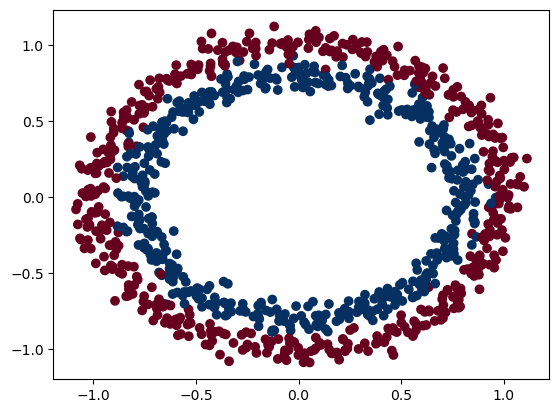

In [67]:
import matplotlib.pyplot as plt
plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.RdBu)

In [68]:
x.shape, y.shape

((1000, 2), (1000,))

In [69]:
import torch
x = torch.from_numpy(x).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)


In [70]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2)

## 2. Building a model

In [71]:
import torch
import torch.nn as nn
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [72]:
x_train = x_train.to(device)
x_test = x_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)
x_train, y_train, x_test, y_test

(tensor([[-0.6434,  0.7795],
         [ 0.5682,  0.8984],
         [-0.3571, -0.7792],
         ...,
         [ 0.6178,  0.8464],
         [ 0.5561,  0.5711],
         [-0.4460, -0.6062]], device='cuda:0'),
 tensor([0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
         0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
         0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0.,
         1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
         1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1.,
         1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
         0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0.,
         0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.,
         1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1.,

In [73]:
class circle_model_v0(nn.Module):
    def __init__(self, input_features=2, hidden_dim=4, output_features=1):
        super(circle_model_v0, self).__init__()
        self.fc1 = nn.Linear(input_features, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_features)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.fc1(x)
        x = self.sigmoid(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [74]:
model_0 = circle_model_v0().to(device)
model_0

circle_model_v0(
  (fc1): Linear(in_features=2, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [75]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=4),
    nn.Linear(in_features=4, out_features=1),
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): Linear(in_features=4, out_features=1, bias=True)
)

In [76]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.1045, -0.3301],
                      [ 0.1802, -0.3258],
                      [-0.0829, -0.2872],
                      [ 0.4691, -0.5582]], device='cuda:0')),
             ('0.bias',
              tensor([-0.3260, -0.1997, -0.4252,  0.0667], device='cuda:0')),
             ('1.weight',
              tensor([[-0.4938,  0.4516, -0.4247,  0.3860]], device='cuda:0')),
             ('1.bias', tensor([0.0832], device='cuda:0'))])

In [77]:
untrained_predict = model_0(x_train)
torch.round(untrained_predict[:5]), y_train[:5]

(tensor([[0.],
         [0.],
         [0.],
         [1.],
         [0.]], device='cuda:0', grad_fn=<RoundBackward0>),
 tensor([0., 0., 1., 0., 1.], device='cuda:0'))

In [78]:
# Set up loss function
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(model_0.parameters(),
                            lr=0.1)

def calculate_accuracy(y_true, y_pred):
    correct = torch.eq(y_pred.round(), y_true).sum().item()
    accuracy = correct / len(y_true)
    return accuracy * 100

In [79]:
# Build a training loop
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(x_test.to(device))
y_logits

tensor([[0.2420],
        [0.1849],
        [0.3023],
        [0.6092],
        [0.0990],
        [0.3068],
        [0.5777],
        [0.5617],
        [0.2200],
        [0.5597],
        [0.5138],
        [0.2760],
        [0.5030],
        [0.3482],
        [0.3340],
        [0.1041],
        [0.5863],
        [0.5906],
        [0.1395],
        [0.1094],
        [0.4075],
        [0.2652],
        [0.4188],
        [0.6142],
        [0.3638],
        [0.3379],
        [0.1132],
        [0.2050],
        [0.5552],
        [0.3139],
        [0.5143],
        [0.1741],
        [0.2280],
        [0.3688],
        [0.6239],
        [0.1664],
        [0.3260],
        [0.1573],
        [0.1641],
        [0.3351],
        [0.4989],
        [0.4572],
        [0.3149],
        [0.2046],
        [0.2742],
        [0.1835],
        [0.5123],
        [0.5595],
        [0.4573],
        [0.1470],
        [0.2807],
        [0.2041],
        [0.3391],
        [0.6078],
        [0.6174],
        [0

In [80]:
y_test

tensor([1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0.,
        1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1.,
        1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0.,
        0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1.,
        0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1.,
        1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0.,
        0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1.,
        0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0.,
        1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1.,
        0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1.,
        0., 1.], device='cuda:0')

In [81]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5602],
        [0.5461],
        [0.5750],
        [0.6478],
        [0.5247],
        [0.5761],
        [0.6405],
        [0.6369],
        [0.5548],
        [0.6364],
        [0.6257],
        [0.5686],
        [0.6232],
        [0.5862],
        [0.5827],
        [0.5260],
        [0.6425],
        [0.6435],
        [0.5348],
        [0.5273],
        [0.6005],
        [0.5659],
        [0.6032],
        [0.6489],
        [0.5900],
        [0.5837],
        [0.5283],
        [0.5511],
        [0.6353],
        [0.5778],
        [0.6258],
        [0.5434],
        [0.5568],
        [0.5912],
        [0.6511],
        [0.5415],
        [0.5808],
        [0.5392],
        [0.5409],
        [0.5830],
        [0.6222],
        [0.6123],
        [0.5781],
        [0.5510],
        [0.5681],
        [0.5457],
        [0.6253],
        [0.6363],
        [0.6124],
        [0.5367],
        [0.5697],
        [0.5509],
        [0.5840],
        [0.6474],
        [0.6496],
        [0

In [82]:
y_preds = torch.round(y_pred_probs)
y_pred_labels = torch.round(torch.sigmoid(model_0(x_test.to(device))))
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))
y_pred_labels.squeeze()

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, Tr

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [83]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 2000
x_train, y_train = x_train.to(device), y_train.to(device)
x_test, y_test = x_test.to(device), y_test.to(device)
for epoch in range(epochs):
    model_0.train()
    y_logits = model_0(x_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train)
    acc = calculate_accuracy(y_train, y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    with torch.inference_mode():
        test_logits = model_0(x_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = calculate_accuracy(y_test, test_pred)
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.5f} | Train Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")

Epoch: 0 | Train Loss: 0.71459 | Train Acc: 50.00% | Test Loss: 0.70425 | Test Acc: 50.00%
Epoch: 10 | Train Loss: 0.70310 | Train Acc: 54.25% | Test Loss: 0.69547 | Test Acc: 55.50%
Epoch: 20 | Train Loss: 0.69860 | Train Acc: 54.25% | Test Loss: 0.69251 | Test Acc: 55.00%
Epoch: 30 | Train Loss: 0.69659 | Train Acc: 51.00% | Test Loss: 0.69154 | Test Acc: 55.00%


Epoch: 40 | Train Loss: 0.69555 | Train Acc: 50.62% | Test Loss: 0.69127 | Test Acc: 53.50%
Epoch: 50 | Train Loss: 0.69493 | Train Acc: 50.38% | Test Loss: 0.69128 | Test Acc: 56.00%
Epoch: 60 | Train Loss: 0.69451 | Train Acc: 49.25% | Test Loss: 0.69138 | Test Acc: 55.50%
Epoch: 70 | Train Loss: 0.69420 | Train Acc: 49.38% | Test Loss: 0.69154 | Test Acc: 54.00%
Epoch: 80 | Train Loss: 0.69397 | Train Acc: 49.38% | Test Loss: 0.69171 | Test Acc: 53.50%
Epoch: 90 | Train Loss: 0.69378 | Train Acc: 49.38% | Test Loss: 0.69189 | Test Acc: 53.00%
Epoch: 100 | Train Loss: 0.69364 | Train Acc: 49.38% | Test Loss: 0.69207 | Test Acc: 53.00%
Epoch: 110 | Train Loss: 0.69352 | Train Acc: 49.25% | Test Loss: 0.69224 | Test Acc: 54.00%
Epoch: 120 | Train Loss: 0.69342 | Train Acc: 49.62% | Test Loss: 0.69241 | Test Acc: 52.50%
Epoch: 130 | Train Loss: 0.69335 | Train Acc: 48.88% | Test Loss: 0.69257 | Test Acc: 54.50%
Epoch: 140 | Train Loss: 0.69328 | Train Acc: 49.50% | Test Loss: 0.69273 | 